In [136]:
import os

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [138]:
url ='https://raw.githubusercontent.com/C4AnN/Models/main/dataset_processing%20(1)/filtered_data_mid_level.csv'
store_sales = pd.read_csv(url)
store_sales.head(10)

,name,price,date,sales
0,HP PAVILION 14-DV0065TX DV0066TX i5-1135G7 8GB...,11999000,2013-01-08,9
1,HP PAVILION 15 CORE i5-8250U/8GB/256GB/TOUCH -...,8700000,2013-01-09,12
2,HP PAVILION 15-EC0107AX R5 3550H 8GB 512GB SSD...,12498000,2013-01-10,9
3,HP PAVILION GAMING 15 DK1041TX i7-10750H - 8G...,14999000,2013-01-11,9
4,HP PAVILION GAMING 15-DK1041TX-CORE 17 10750H-...,14909520,2013-01-12,7
5,HP PAVILION Gaming 15-dk1064TX i5-10300H 8GB 5...,15900000,2013-01-13,10
6,"HP Pavilion 13 - AN1035TU-34TU - i5-1035G1, 13...",10850000,2013-01-16,7
7,HP Envy X360 13 AMD RYZEN 7 4700U 8GB 512GB W1...,15099000,2013-01-22,7
8,HP Envy X360 13-AG0023AU Ryzen 7 SSD 512GB Win 10,15399000,2013-01-23,9
9,HP Envy X360 Convertible Ryzen 7 SSD 512GB,8750000,2013-01-24,8


In [139]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    1994 non-null   object
 1   price   1994 non-null   int64 
 2   date    1994 non-null   object
 3   sales   1994 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 62.4+ KB


In [140]:
store_sales = store_sales.drop(['name','price'], axis=1)

In [141]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1994 non-null   object
 1   sales   1994 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.3+ KB


In [142]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [143]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1994 non-null   datetime64[ns]
 1   sales   1994 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 31.3 KB


In [144]:
store_sales['date'] = store_sales['date'].dt.to_period("M")
monthly_sales = store_sales.groupby('date').sum().reset_index()

In [145]:
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

In [146]:
monthly_sales.head(10)

,date,sales
0,2013-01-01,707
1,2013-02-01,710
2,2013-03-01,745
3,2013-04-01,937
4,2013-05-01,1021
5,2013-06-01,1321
6,2013-07-01,1130
7,2013-08-01,1088
8,2013-09-01,1027
9,2013-10-01,1097


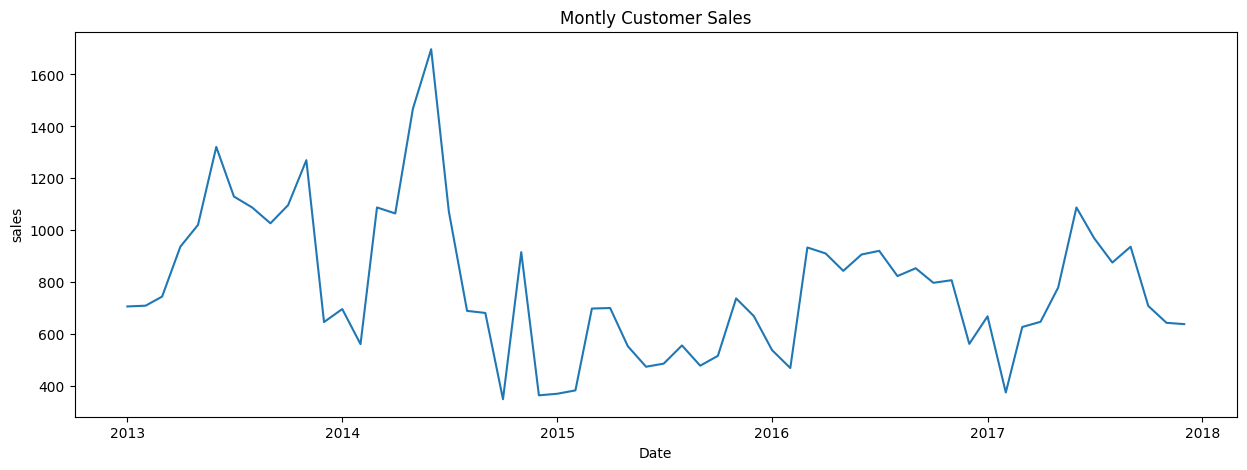

In [147]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales")
plt.show()

In [148]:
# Sales_diff = Selisih Total Penjualan Dengan Bulan Sebelumnya (Increase (+) atau Decrease (-) )
# Contoh Sales_diff pada Row 2 date 2013-03-01 didapatkan dari
# jumlah sales pada date 2013-03-01 (617382) - date 2013-02-01 (459417) didapatkan sales_diff = 157965.0

monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,710,3.0
2,2013-03-01,745,35.0
3,2013-04-01,937,192.0
4,2013-05-01,1021,84.0
5,2013-06-01,1321,300.0
6,2013-07-01,1130,-191.0
7,2013-08-01,1088,-42.0
8,2013-09-01,1027,-61.0
9,2013-10-01,1097,70.0
10,2013-11-01,1270,173.0


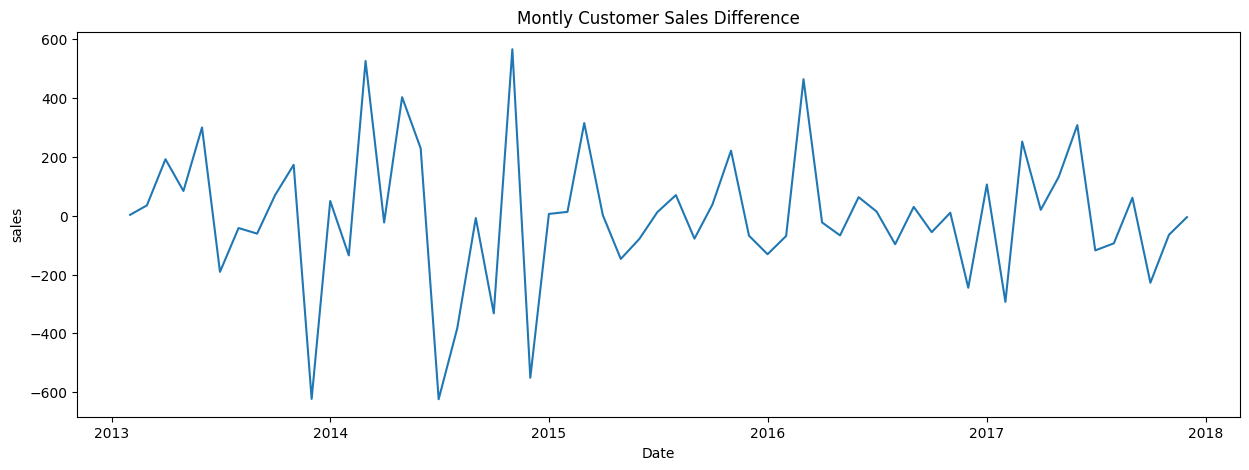

In [149]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'], monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("sales")
plt.title("Montly Customer Sales Difference")
plt.show()

In [150]:
supervised_data = monthly_sales.drop(['date', 'sales'], axis=1)

In [151]:
for i in range(1,13):
  col_name = 'month_' + str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)

,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,-135.0,50.0,-623.0,173.0,70.0,-61.0,-42.0,-191.0,300.0,84.0,192.0,35.0,3.0
1,526.0,-135.0,50.0,-623.0,173.0,70.0,-61.0,-42.0,-191.0,300.0,84.0,192.0,35.0
2,-23.0,526.0,-135.0,50.0,-623.0,173.0,70.0,-61.0,-42.0,-191.0,300.0,84.0,192.0
3,403.0,-23.0,526.0,-135.0,50.0,-623.0,173.0,70.0,-61.0,-42.0,-191.0,300.0,84.0
4,229.0,403.0,-23.0,526.0,-135.0,50.0,-623.0,173.0,70.0,-61.0,-42.0,-191.0,300.0
5,-624.0,229.0,403.0,-23.0,526.0,-135.0,50.0,-623.0,173.0,70.0,-61.0,-42.0,-191.0
6,-383.0,-624.0,229.0,403.0,-23.0,526.0,-135.0,50.0,-623.0,173.0,70.0,-61.0,-42.0
7,-8.0,-383.0,-624.0,229.0,403.0,-23.0,526.0,-135.0,50.0,-623.0,173.0,70.0,-61.0
8,-332.0,-8.0,-383.0,-624.0,229.0,403.0,-23.0,526.0,-135.0,50.0,-623.0,173.0,70.0
9,566.0,-332.0,-8.0,-383.0,-624.0,229.0,403.0,-23.0,526.0,-135.0,50.0,-623.0,173.0


In [152]:
# Previous 12 Month
train_data = supervised_data[:-12]
# The Coming 12 Month
test_data = supervised_data[-12:]
print("Train Data Shape: ", train_data.shape)
print("Test Data Shape: ", test_data.shape)

Train Data Shape:  (35, 13)
Test Data Shape:  (12, 13)


In [153]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [154]:
X_train, y_train = train_data[:,1:], train_data[:,0:1]
X_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)
print("x_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

x_train shape :  (35, 12)
y_train shape :  (35,)
x_test shape :  (12, 12)
y_test shape :  (12,)


In [155]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)

In [156]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[563, 669, 376, 628, 648, 780, 1088, 970, 876, 937, 709, 644, 639]


In [157]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pre = lr_model.predict(X_test)

In [158]:
lr_pre = lr_pre.reshape(-1,1)
# This is a set matrix - contain the input features of the data, and also the predict output
lr_pre_test_set = np.concatenate([lr_pre, X_test], axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [159]:
result_list= []
for index in range(0, len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0] + act_sales[index])
lr_pre_series = pd.Series(result_list, name="Linear Prediction")
predict_df = predict_df.merge(lr_pre_series, left_index=True, right_index=True)

In [160]:
# print(predict_df)
lr_mse = np.sqrt(mean_squared_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'], monthly_sales['sales'][-12:])
print("Linaer Regression MSE : ", lr_mse )
print("Linaer Regression MAE : ", lr_mae )
print("Linaer Regression R2 : ", lr_r2 )

Linaer Regression MSE :  148.58453527118223
Linaer Regression MAE :  113.62589790336723
Linaer Regression R2 :  -0.5018398242104487


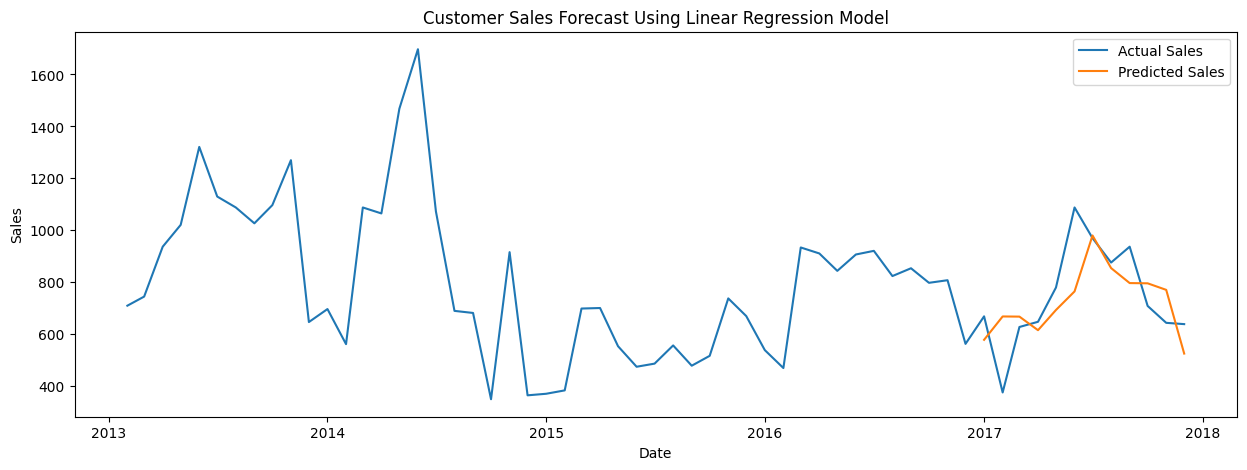

In [161]:
plt.figure(figsize=(15,5))
# Actual Sales
plt.plot(monthly_sales['date'], monthly_sales['sales'])
# Predicted Sales
plt.plot(predict_df['date'], predict_df['Linear Prediction'])
plt.title("Customer Sales Forecast Using Linear Regression Model")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(['Actual Sales', 'Predicted Sales'])
plt.show()